# Face Recognition with Siamese Networks

In this notebook, we'll implement a simple siamese network for a face recognition application. As our dataset, we'll use the *ORL Database of Faces* (kindly available <a href="https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html">here</a>). 

A siamese network finds to learn a feature representation where similar datapoints are near given an energy function $E$ and dissimilar samples are separated. For this, we need a loss function which represents such representation. This kind of loss functions are called *distance-based loss functions*. In this case, we'll use the *contrastive loss*. 

This requires a new set of prerequisites. Our dataset needs a special configuration in duples labeled as *genuine* if the pairs are from the same identity or *imposite* otherwise. Therefore, is training sample has the shape $((X_1, X_2), Y)$ where $Y \in {0, 1}$ for genuine and imposite, respectively.

Now that we have a set of tasks, let's get started!

In [1]:
import os
import zipfile

import matplotlib.pyplot as plt

from mxnet import autograd, init, gluon, nd, context as ctx
from mxnet.gluon import nn, data as gdata
from PIL import Image

In [2]:
plt.style.use(["seaborn-notebook"])

In [3]:
def try_gpu(i=0):
    return ctx.gpu(i) if ctx.num_gpus() > i else ctx.cpu() 

## Preparing the Dataset

We start by downloading the dataset and process it to fit in our network. First, we define some constants to prepare the data. 

In [4]:
DATA_PATH = os.path.join("data", "orl_faces")
SAMPLE_SIZE = 20000
BATCH_SIZE = 64
VALID_SIZE = 0.2

Then, we download the dataset from the website as a ZIP and extract the data into `DATA_PATH`

In [5]:
URL = "http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip"
download_path = gluon.utils.download(URL)

with zipfile.ZipFile(download_path, "r") as zp:
    zp.extractall(DATA_PATH)

Each image is in `pgm` format, which isn't readable directly by MXNet. However, we can load it with PIL and then convert it to NDArray format. Also, we might want to perform some image transformation, such as rescale or augmentations, therefore we pass the image through such transform. The `imread` function implements such behaviour.

In [6]:
def imread(filepath, transform):
    img = nd.array(Image.open(filepath)).expand_dims(axis=2)
    return transform(img)

We need to generate **genuine pairs** and **imposite pairs** with a binary label. Let's encapsulate this into a function.

In [7]:
def get_orl_faces(size, total_sample_size, transform):
    # Read a single image to extract image properties.
    _img = imread(os.path.join(DATA_PATH, "s1", "1.pgm"), transform)
    height, width = _img.shape[1:]
    
    #= Generating genuine pairs =#
    # Now we generate a genuine tensor with shape [total_sample_size, size, channels, height, width]
    X_genuine = nd.zeros([total_sample_size, size, 1, height, width])
    y_genuine = nd.zeros(total_sample_size)
    count = 0
    
    # Iterate over the different identities
    for i in range(1, 41):
        # Generate total_sample_size // 40 samples per identity
        for j in range(total_sample_size // 40):
            # Make sure we aren'r reading the same images!
            idx1, idx2 = nd.random.shuffle(nd.arange(1, 11))[:2]
            idx1, idx2 = int(idx1.asscalar()), int(idx2.asscalar())
            
            # Read images and store them in the tensor
            img1 = imread(os.path.join(DATA_PATH, f"s{i}", f"{idx1}.pgm"), transform)
            img2 = imread(os.path.join(DATA_PATH, f"s{i}", f"{idx2}.pgm"), transform)
            X_genuine[count, 0, :, :, :] = img1
            X_genuine[count, 1, :, :, :] = img2
            
            count += 1
    
    #= Generating imposite pairs =#
    # Now we generate a imposite tensor with shape [total_sample_size, size, channels, height, width]
    X_imposite = nd.zeros_like(X_genuine)
    y_imposite = nd.ones_like(y_genuine)
    count = 0
    # Instead of sampling images, this time we sample directories
    for i in range(total_sample_size // 10):
        for j in range(1, 11):
            #  Make sure we are not in the same directory
            idx1, idx2 = nd.random.shuffle(nd.arange(1, 41))[:2]
            idx1, idx2 = int(idx1.asscalar()), int(idx2.asscalar())
            
            # Read images and store them in the tensor
            img1 = imread(os.path.join(DATA_PATH, f"s{idx1}", f"{j}.pgm"), transform)
            img2 = imread(os.path.join(DATA_PATH, f"s{idx2}", f"{j}.pgm"), transform)
            X_imposite[count, 0, :, :, :] = img1
            X_imposite[count, 1, :, :, :] = img2
            
            count += 1
    
    #= Generate and shuffle the dataset =#
    random_idx = nd.random.shuffle(nd.arange(total_sample_size * 2))
    X = nd.concatenate([X_genuine, X_imposite], axis=0)
    y = nd.concatenate([y_genuine, y_imposite], axis=0)
    
    X = X[random_idx]
    y = y[random_idx]
    
    return X, y

We use `ToTensor`to prepare our image dataset to be fed into our siamese network. It reshape each image from `(height, width, channels)` shape to `(channels, height, width)`. Also it tranforms the image from bytes to float in the `[0, 1]` range. If you need more augmentations, you need to create a `Compose` transform.

In [8]:
transform = gdata.vision.transforms.ToTensor()

Now we retrieve our data and split them into train and validation using the specified validation size. As we shuffled the dataset since we generated it, we can simply extract the first `SAMPLE_SIZE * VALID_SIZE` for validation and leave the rest for training.

In [9]:
X, y = get_orl_faces(2, SAMPLE_SIZE // 2, transform)
valid_index = int(SAMPLE_SIZE * VALID_SIZE)

X_valid, y_valid = X[:valid_index], y[:valid_index]
X_train, y_train = X[valid_index:], y[valid_index:]

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_valid.shape[0]}")

Training samples: 16000
Validation samples: 4000


Now let's define a function to display such pairs!

In [10]:
def display_pair(pair, label, dist=None):
    fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
    
    imleft = pair[0, 0].asnumpy()
    imright = pair[1, 0].asnumpy()
    
    left.imshow(imleft, cmap="gray")
    right.imshow(imright, cmap="gray")
    
    title = "Imposite" if label else "Genuine"
    if dist:
        title += " (predicted dissimilarity: {:.2f})".format(dist)
        
    left.get_xaxis().set_visible(False)
    left.get_yaxis().set_visible(False)
    right.get_xaxis().set_visible(False)
    right.get_yaxis().set_visible(False)
    
    fig.suptitle(title)

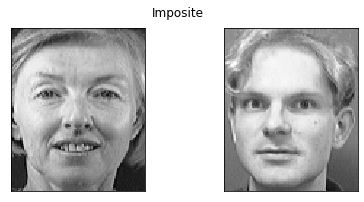

In [11]:
display_pair(X_train[1], y_train[1])

Now we can create our data iterators.

In [12]:
train_ds = gdata.ArrayDataset(X_train, y_train)
valid_ds = gdata.ArrayDataset(X_valid, y_valid)

train_iter = gdata.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_iter = gdata.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

## Defining the Energy Function

This is our similarity function. In this case, we'll use the Euclidean distance, which is implemented in MXNet as the L2 norm. The parameter `F` is used during the network definition for hybridization.

In [13]:
def euclidean_distance(F, x1, x2):
    return F.norm(x1 - x2, axis=1)

## Defining the Contrastive Loss

In the original paper from Hadsell, Chopra and LeCun <a href="http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf">available here</a>, the contrastive loss is defined as

$$
L = (1 - Y) \frac{1}{2}(D_W)^2 + (Y)\frac{1}{2} \{ max(0, m - D_W) \} ^2
$$

where $D_W$ is the Euclidean distance for the embeddings generated by our function $G_W$ for any two images $X_1, X_2$.

$$
D_W(X_1, X_2) = \left\| G_W(X_1) - G_W(X_2) \right\|_2
$$

and $m$ is a margin which limits the loss contribution of imposite pairs. Finally, we can extract the fractional part and calculate the average of the calculations for the batch:

$$
L = mean \left( (1-Y) (D_W)^2 + (Y) \{max(0, m - D_W)\}^2 \right)
$$


In [14]:
def contrastive_loss(Y, D, m):
    losses = (1 - Y) * nd.square(D) + (Y) * nd.square(nd.maximum(0, m - D))
    return nd.mean(losses)

## Creating our Model

A siamese network is defined as two network sharing the same weights generating a distance between their inputs as defined by the energy function $E$. We can have a single network generating the embedding for both images and then return the Euclidean distance as the network's output. The function $G_W$ can be any function capable of returning and embedding of the desired dimension. Here, we define as $G_W$ a small CNN network.

In [15]:
class SiameseNetwork(nn.HybridBlock):
    def __init__(self, output, **kwargs):
        super(SiameseNetwork, self).__init__(**kwargs)
        self.inner = nn.HybridSequential()
        self.inner.add(
            nn.Conv2D(15, kernel_size=6, activation="relu"),
            nn.MaxPool2D(2, 2),
            nn.Dropout(0.25),

            nn.Conv2D(30, kernel_size=9, activation="relu"),
            nn.MaxPool2D(2, 2),
            nn.Dropout(0.25),

            nn.Flatten(),

            nn.Dense(128, activation="relu"),
            nn.Dropout(0.1),
            nn.Dense(output, activation="relu")
        )
    def hybrid_forward(self, F, X1, X2):
        x1 = self.inner(X1)
        x2 = self.inner(X2)
        dist = euclidean_distance(F, x1, x2)
        
        return dist
        

## Evaluation Functions
This evaluation function calculates the average contrastive loss in a data iterator using the provided network and margin.

In [16]:
def evaluate(net, data_iter, margin, ctx):
    losses = []
    for X, y in data_iter:
        X = X.as_in_context(ctx)
        y = y.as_in_context(ctx)

        dist = net(X[:, 0], X[:, 1])
        
        losses.append(contrastive_loss(y, dist, margin).asscalar())
        
    return sum(losses) / len(losses)

## Training Function

We are almost done! Now we need to define out training function.

In [17]:
def train_siamese_network(net, train_iter, val_iter, num_epochs, trainer, margin, log_frequency=20, ctx=try_gpu()):    
    train_losses = []
    train_metrics = {
        "valid_loss": [],
        "train_loss": [],
    }
    
    for epoch in range(1, num_epochs + 1):
        total_iters = len(train_iter)
        for i, (X, y) in enumerate(train_iter):
            X = X.as_in_context(ctx)
            y = y.as_in_context(ctx)
            with autograd.record():
                dist = net(X[:, 0], X[:, 1])
                l = contrastive_loss(y, dist, margin)

            l.backward()
            trainer.step(X.shape[0])
            
            if i % log_frequency == 0:
                print("Epoch {:3d}/{:3d} - [{:4d}/{:4d}]: Contrastive loss (train): {:.4f}".format(
                    epoch, num_epochs, i, total_iters, l.asscalar(),
                ))
                train_losses.append(l.asscalar())
        
        #= Epoch metrics =#
        valid_loss = evaluate(net, valid_iter, margin, ctx)
        train_loss = evaluate(net, train_iter, margin, ctx)
        
        print()
        print("========= EPOCH {:3d} =========".format(epoch))
        print("Epoch {:3d}/{:3d}: Loss (train): {:.4f}\tLoss (valid): {:.4f}".format(
            epoch, num_epochs, train_loss, valid_loss
        ))
        print("============================")
        print()
        
        train_metrics["valid_loss"].append(valid_loss)
        train_metrics["train_loss"].append(train_loss)
        
    return train_losses, train_metrics

## Training
Now we instantiate and train our model! Let's use an output embedding vector of 32 elements and set the margin for contrastive loss to 1. 

In [18]:
LR = 0.0005
NUM_EPOCHS = 30
MARGIN = 1
net = SiameseNetwork(32)
net.hybridize()
net.initialize(init.Xavier(), ctx=try_gpu())

trainer = gluon.Trainer(net.collect_params(), "adam", {"learning_rate": LR})

train_metrics = train_siamese_network(net, train_iter, valid_iter, NUM_EPOCHS, trainer, MARGIN)

Epoch   1/ 30 - [   0/ 250]: Contrastive loss (train): 0.2711
Epoch   1/ 30 - [  20/ 250]: Contrastive loss (train): 0.2357
Epoch   1/ 30 - [  40/ 250]: Contrastive loss (train): 0.1894
Epoch   1/ 30 - [  60/ 250]: Contrastive loss (train): 0.1035
Epoch   1/ 30 - [  80/ 250]: Contrastive loss (train): 0.1364
Epoch   1/ 30 - [ 100/ 250]: Contrastive loss (train): 0.1201
Epoch   1/ 30 - [ 120/ 250]: Contrastive loss (train): 0.1265
Epoch   1/ 30 - [ 140/ 250]: Contrastive loss (train): 0.1113
Epoch   1/ 30 - [ 160/ 250]: Contrastive loss (train): 0.0949
Epoch   1/ 30 - [ 180/ 250]: Contrastive loss (train): 0.1029
Epoch   1/ 30 - [ 200/ 250]: Contrastive loss (train): 0.0915
Epoch   1/ 30 - [ 220/ 250]: Contrastive loss (train): 0.1005
Epoch   1/ 30 - [ 240/ 250]: Contrastive loss (train): 0.0846

========= EPOCH   1 =========
Epoch   1/ 30: Loss (train): 0.0937	Loss (valid): 0.0943

Epoch   2/ 30 - [   0/ 250]: Contrastive loss (train): 0.0762
Epoch   2/ 30 - [  20/ 250]: Contrastive lo


========= EPOCH   9 =========
Epoch   9/ 30: Loss (train): 0.0101	Loss (valid): 0.0119

Epoch  10/ 30 - [   0/ 250]: Contrastive loss (train): 0.0141
Epoch  10/ 30 - [  20/ 250]: Contrastive loss (train): 0.0167
Epoch  10/ 30 - [  40/ 250]: Contrastive loss (train): 0.0166
Epoch  10/ 30 - [  60/ 250]: Contrastive loss (train): 0.0175
Epoch  10/ 30 - [  80/ 250]: Contrastive loss (train): 0.0286
Epoch  10/ 30 - [ 100/ 250]: Contrastive loss (train): 0.0195
Epoch  10/ 30 - [ 120/ 250]: Contrastive loss (train): 0.0190
Epoch  10/ 30 - [ 140/ 250]: Contrastive loss (train): 0.0229
Epoch  10/ 30 - [ 160/ 250]: Contrastive loss (train): 0.0244
Epoch  10/ 30 - [ 180/ 250]: Contrastive loss (train): 0.0213
Epoch  10/ 30 - [ 200/ 250]: Contrastive loss (train): 0.0172
Epoch  10/ 30 - [ 220/ 250]: Contrastive loss (train): 0.0257
Epoch  10/ 30 - [ 240/ 250]: Contrastive loss (train): 0.0109

========= EPOCH  10 =========
Epoch  10/ 30: Loss (train): 0.0078	Loss (valid): 0.0092

Epoch  11/ 30 - 

Epoch  18/ 30 - [ 240/ 250]: Contrastive loss (train): 0.0086

========= EPOCH  18 =========
Epoch  18/ 30: Loss (train): 0.0036	Loss (valid): 0.0049

Epoch  19/ 30 - [   0/ 250]: Contrastive loss (train): 0.0166
Epoch  19/ 30 - [  20/ 250]: Contrastive loss (train): 0.0083
Epoch  19/ 30 - [  40/ 250]: Contrastive loss (train): 0.0165
Epoch  19/ 30 - [  60/ 250]: Contrastive loss (train): 0.0127
Epoch  19/ 30 - [  80/ 250]: Contrastive loss (train): 0.0107
Epoch  19/ 30 - [ 100/ 250]: Contrastive loss (train): 0.0060
Epoch  19/ 30 - [ 120/ 250]: Contrastive loss (train): 0.0107
Epoch  19/ 30 - [ 140/ 250]: Contrastive loss (train): 0.0110
Epoch  19/ 30 - [ 160/ 250]: Contrastive loss (train): 0.0057
Epoch  19/ 30 - [ 180/ 250]: Contrastive loss (train): 0.0092
Epoch  19/ 30 - [ 200/ 250]: Contrastive loss (train): 0.0133
Epoch  19/ 30 - [ 220/ 250]: Contrastive loss (train): 0.0126
Epoch  19/ 30 - [ 240/ 250]: Contrastive loss (train): 0.0097

========= EPOCH  19 =========
Epoch  19/ 3

Epoch  27/ 30 - [ 220/ 250]: Contrastive loss (train): 0.0034
Epoch  27/ 30 - [ 240/ 250]: Contrastive loss (train): 0.0017

========= EPOCH  27 =========
Epoch  27/ 30: Loss (train): 0.0024	Loss (valid): 0.0037

Epoch  28/ 30 - [   0/ 250]: Contrastive loss (train): 0.0051
Epoch  28/ 30 - [  20/ 250]: Contrastive loss (train): 0.0024
Epoch  28/ 30 - [  40/ 250]: Contrastive loss (train): 0.0034
Epoch  28/ 30 - [  60/ 250]: Contrastive loss (train): 0.0051
Epoch  28/ 30 - [  80/ 250]: Contrastive loss (train): 0.0060
Epoch  28/ 30 - [ 100/ 250]: Contrastive loss (train): 0.0038
Epoch  28/ 30 - [ 120/ 250]: Contrastive loss (train): 0.0039
Epoch  28/ 30 - [ 140/ 250]: Contrastive loss (train): 0.0027
Epoch  28/ 30 - [ 160/ 250]: Contrastive loss (train): 0.0041
Epoch  28/ 30 - [ 180/ 250]: Contrastive loss (train): 0.0052
Epoch  28/ 30 - [ 200/ 250]: Contrastive loss (train): 0.0075
Epoch  28/ 30 - [ 220/ 250]: Contrastive loss (train): 0.0058
Epoch  28/ 30 - [ 240/ 250]: Contrastive lo

## Evaluation

First, we plot the loss decay as we train our network.

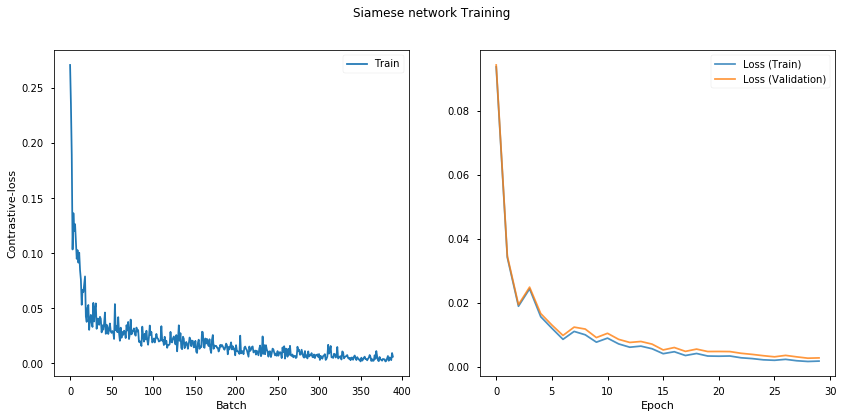

In [19]:
fig, (train, valid) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

fig.suptitle("Siamese network Training")

train.plot(train_metrics[0], label="Train")
train.set_ylabel("Contrastive-loss")
train.set_xlabel("Batch")
train.legend()

valid.plot(train_metrics[1]["train_loss"], label="Loss (Train)", alpha=0.8)
valid.plot(train_metrics[1]["valid_loss"], label="Loss (Validation)", alpha=0.8)

valid.set_xlabel("Epoch")
valid.legend();

Now we can use our siamese network to evaluate any pair of faces and measure its similarity! (remember the covariance shift, though). Let's define a function to evaluate how good our network is for discriminating similar faces!

In [20]:
def compute_accuracy(y, y_pred, threshold):
    mask = y_pred.asnumpy().ravel() < threshold

    if not any(mask):
        return 0
    
    return 1 - y.asnumpy()[mask].mean()

Let's review our validation accuracy!

In [21]:
accs = []

for X, y in valid_iter:
    X = X.as_in_context(try_gpu())
    y = y.as_in_context(try_gpu())
    
    dists = net(X[:, 0], X[:, 1])
    
    accs.append(compute_accuracy(y, dists, 0.05))

sum(accs) / len(accs)

1.0

## Making predictions

Now our model is trained and we can use it to make predictions. We need to pass it a pair of images and it will return the similarity (the lower it is, the more similar the faces are)

In [22]:
X, y = valid_ds[:3]
X = X.as_in_context(try_gpu())
D = net(X[:, 0], X[:, 1])


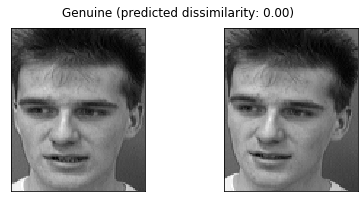

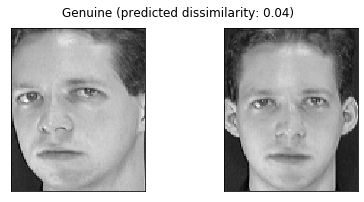

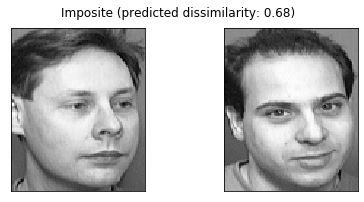

In [23]:
for i in range(3):
    display_pair(X[i], y[i], D[i].asscalar())

Now store the model for future usage.

In [24]:
models_path = os.path.join("models", "miniorl")
if not os.path.exists(models_path):
    os.makedirs(models_path)
    
net.export("models/miniorl/miniorl")